In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from random import randint
import numpy as np
import time
import os
import sys
import numpy
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from models import Alastor
from functions import *

Setting parameters

In [52]:
num_epochs = 600
seq_length = 2000
learning_rate = 0.0002
n_seq = 5000
output_sz=1
LV = 1

Load and process data

In [53]:
data_X = file_to_list(f"pbmc1_data/7000_data_X").float()
data_size = int(data_X.size()[0])
data_X_new= torch.transpose(data_X,1,2)
data_X_CNN = data_X_new.view(data_size,4,seq_length)
data_Y = torch.from_numpy(numpy.loadtxt(f"pbmc1_data/7000_data_Y")[:,LV]).float()
data_X0 = data_X_CNN[0:n_seq]
data_Y0 = data_Y[0:n_seq].unsqueeze(dim=1)
print (data_X0.size())
print (data_Y0.size())

torch.Size([5000, 4, 2000])
torch.Size([5000, 1])


Create network 

In [54]:
class Alastor (nn.Module):
    def __init__(self, n_channel=4, max_seq_len=2000, num_targets=4+1,
                conv1kc=32, conv1ks=15, conv1st=1, conv1pd=7, pool1ks=8, pdrop1=0.5, #conv_block_1 parameters
                conv2kc=48, conv2ks=3, conv2st=1, conv2pd=3, pool2ks=4 , pdrop2=0.5, #conv_block_2 parameters
                conv3kc=32, conv3ks=3, conv3st=1, conv3pd=3, pool3ks=4, pdrop3=0.4, #conv_block_3 parameters
                convdc=7, convd1kc=32 , convd1ks=3, convd2kc=96 , convd2ks=1, pdropd=0.3,
                conv4kc=64, conv4ks=1, conv4st=1, conv4pd=0, pdrop4=0.5):
        super(Alastor, self).__init__()

        self.convdc = convdc
        self.device = 'cpu'
        self.max_seq_len = max_seq_len
        self.num_targets = num_targets

        conv1pd = int((conv1ks - 1) / 2)
        conv2pd = int((conv2ks - 1) / 2)
        conv3pd = int((conv3ks - 1) / 2)

        convd2kc = int(conv3kc)
        
        self.conv_block_1 = nn.Sequential(
            #nn.GELU(),
            nn.Conv1d(n_channel, conv1kc, kernel_size=conv1ks, stride=conv1st, padding=conv1pd, bias=False),
            nn.BatchNorm1d(conv1kc, momentum=0.9, affine=True),
            nn.MaxPool1d(kernel_size=pool1ks),
            nn.Dropout(p=pdrop1))
                
        self.conv_block_2 = nn.Sequential(
            #nn.GELU(),
            nn.Conv1d(conv1kc, conv2kc, kernel_size=conv2ks, stride=conv2st, padding=conv2pd, bias=False),
            nn.BatchNorm1d(conv2kc, momentum=0.9, affine=True),
            nn.MaxPool1d(kernel_size=pool2ks),
            nn.Dropout(p=pdrop2))
        
        self.conv_block_3 = nn.Sequential(
            #nn.GELU(),
            nn.Conv1d(conv2kc, conv3kc, kernel_size=conv3ks, stride=conv3st, padding=conv3pd, bias=False),
            nn.BatchNorm1d(conv3kc, momentum=0.9, affine=True),
            nn.MaxPool1d(kernel_size=pool3ks),
            nn.Dropout(p=pdrop3))
        
        self.dilations = nn.ModuleList()
        
        for i in range(convdc):
            padding = 2**(i)
            self.dilations.append(nn.Sequential(
                #nn.GELU(),
                nn.Conv1d(conv3kc, convd1kc, kernel_size=convd1ks, padding=padding, dilation=2**i, bias=False),
                nn.BatchNorm1d(convd1kc, momentum=0.9, affine=True), 
                #nn.GELU(),
                nn.Conv1d(convd1kc, convd2kc, kernel_size=convd2ks, padding=0, bias=False),
                nn.BatchNorm1d(convd2kc, momentum=0.9, affine=True), 
                nn.Dropout(p=pdropd)))
            
        self.conv_block_4 = nn.Sequential(
            #nn.GELU(),
            nn.Conv1d(convd2kc, conv4kc, kernel_size=conv4ks, stride=conv4st, padding=conv4pd, bias=False),
            nn.BatchNorm1d(conv4kc, momentum=0.9, affine=True), 
            nn.Dropout(p=pdrop4)) 
        
        self.conv_block_5 = nn.Sequential(
            #nn.GELU(),
            nn.Linear(conv4kc, 1, bias=True),
            nn.Flatten())
        
        self.mu_block = nn.Sequential(
            nn.Linear(int(self.max_seq_len / (2**7)), 256),
            nn.BatchNorm1d(256),
            nn.Linear(256, 1)
        )
        
    def forward (self, seq):
        
        out1 = self.conv_block_1(seq)
        out1 = self.conv_block_2(out1)
        out1 = self.conv_block_3(out1)
        current = out1
        for i in range(self.convdc):
            residual = self.dilations[i](current)
            current = current.add(residual)
        
        out = self.conv_block_4(current)
        out = out.transpose(1, 2)
        out = self.conv_block_5(out)
        out = self.mu_block (out)
        return (out)
        
    def compile (self, device = 'cpu'):
        self.to(device)
        self.device = device

Create network 

In [55]:

alastor = Alastor()
model =alastor
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.0228662, weight_decay=1e-6 )
optimizer = torch.optim.Adam(model.parameters(),lr=0.02286 )
lr_sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
            mode='min',
            factor=0.1,
            patience=5,
            threshold=0.0001,
            threshold_mode='rel',
            cooldown=0,
            min_lr=0,
            eps=1e-08)


Split data 

In [56]:
train_data1, test_data, train_label1, test_label = train_test_split(data_X0, data_Y0, test_size=0.1, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data1, train_label1, test_size=0.4, random_state=42)
val_train_data, rest_data, val_train_label, rest_label = train_test_split(train_data, train_label, test_size=0.3, random_state=42)
# Final_Test_data = test_data + valid_data + val_train_data
# Final_Test_Label = test_label + valid_label + val_train_label

Train model

In [57]:
start = time.time()
x =[]
err =[]
acc =[]
mse_vals = []
rmse_vals = []
nrmse_vals = []
RSE_vals =[]
valid_rmse = []
for epoch in range (num_epochs):
    running_mse = 0
    running_rmse = 0
    running_nrmse = 0
    running_RSE = 0
    valid_running_rmse = 0
    running_loss=0
    num_batches=0
    correct=0
    data_size=(train_data.size()[0])
    training_size = data_size
    batch_size =20
  
    for count in range (0, training_size, batch_size):
        optimizer.zero_grad()
        minibatch_data = train_data[count:count+batch_size]
        minibatch_label = train_label [count:count+batch_size]
        
        batch_size = (minibatch_data.size()[0])
        inputs = minibatch_data.view(batch_size,4,seq_length)
        scores = model(inputs)
        loss = criterion(scores, minibatch_label)
        #Add L2 regularization
        l2_lambda = 0.000001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        running_loss+=loss.detach().item()
        
        
        num_batches +=1
        elapsed_time = time.time()-start
        x.append(epoch)
        mse, rmse, nrmse, RSE = evaluation_regression(minibatch_label, scores)
        running_mse += mse
        running_rmse +=rmse
        running_nrmse += nrmse
        running_RSE += RSE

    total_mse = running_mse/num_batches
    total_rmse = running_rmse/num_batches
    total_nrmse = running_nrmse/num_batches
    total_RSE = running_RSE/num_batches
    total_vrmse = valid_running_rmse/num_batches
    
    
    valid_scores = model (valid_data)
    vmse, vrmse, vnrmse, vRSE = evaluation_regression(valid_label, valid_scores)
    mse_vals.append (total_mse)
    rmse_vals.append(total_rmse)
    nrmse_vals.append(total_nrmse)
    RSE_vals.append(total_RSE)
    valid_rmse.append(vrmse)
    total_loss = 100*(running_loss/num_batches)
    lr_sched.step(vrmse)
    if epoch %5 ==0 :
        print ('\n\n Epoch', epoch)
        print (f'Training: \t loss={total_loss}, \t rmse={total_rmse},  \t RSE={total_RSE}, \n Validation: \t RMSE={vrmse} ' )





 Epoch 0
Training: 	 loss=281.42278618282745, 	 rmse=1.5843500828545445,  	 RSE=1.7001884659131368, 
 Validation: 	 RMSE=1.63167214613174 


 Epoch 5
Training: 	 loss=217.125901778539, 	 rmse=1.3728860708956285,  	 RSE=1.0591170584713971, 
 Validation: 	 RMSE=1.598810203558053 


 Epoch 10
Training: 	 loss=215.49274267973723, 	 rmse=1.367876450918757,  	 RSE=1.0508442022182323, 
 Validation: 	 RMSE=1.5933826247508889 


 Epoch 15
Training: 	 loss=215.11889534967915, 	 rmse=1.364549945987958,  	 RSE=1.0424364809636717, 
 Validation: 	 RMSE=1.596177888464671 


 Epoch 20
Training: 	 loss=214.4150266713566, 	 rmse=1.3645757295115606,  	 RSE=1.0464743468496533, 
 Validation: 	 RMSE=1.597101987468889 


 Epoch 25
Training: 	 loss=214.1913277021161, 	 rmse=1.3624981941840122,  	 RSE=1.040074606736501, 
 Validation: 	 RMSE=1.5947552670793852 


 Epoch 30
Training: 	 loss=215.03109009177598, 	 rmse=1.3655344359193893,  	 RSE=1.0465209148548267, 
 Validation: 	 RMSE=1.598955293169973 


 Epoc

torch.Size([2700])


<function matplotlib.pyplot.show(*args, **kw)>

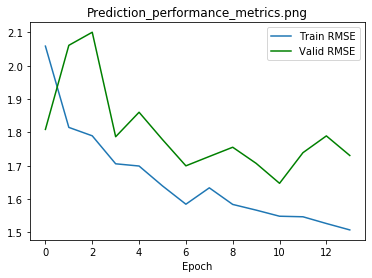

In [ ]:
final_scores = model(train_data).squeeze()
print (final_scores.size())
array = final_scores.data.cpu().numpy()
numpy.savetxt ('output.csv',array)
plt.figure(100)
#plt.plot (range(num_epochs), mse_vals, label= 'Train MSE')
plt.plot (range(num_epochs), rmse_vals, label= 'Train RMSE')
#plt.plot (range(num_epochs), RSE_vals, label='Train RSE')
plt.plot (range(num_epochs), valid_rmse, 'g-', label='Valid RMSE' )
plt.title("Prediction_performance_metrics.png")
plt.xlabel ('Epoch')
plt.legend(loc='upper right')
plt.savefig("Prediction_performamce.png")
plt.show
#scatter_plot (train_label, final_scores, LV)

/anaconda3/envs/theano/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/anaconda3/envs/theano/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
No handles

<Figure size 432x288 with 0 Axes>

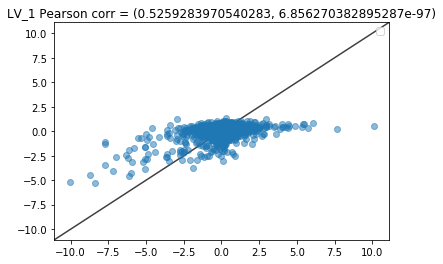

In [ ]:

A = np.array(train_label.detach().numpy(), dtype=np.float)
A = A.flatten()
final_scores.detach().numpy()
B = np.array(final_scores.detach().numpy(), dtype=np.float)
B = B.flatten()
scatter_plot (A, B, LV)

/anaconda3/envs/theano/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/anaconda3/envs/theano/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
No handles

<Figure size 432x288 with 0 Axes>

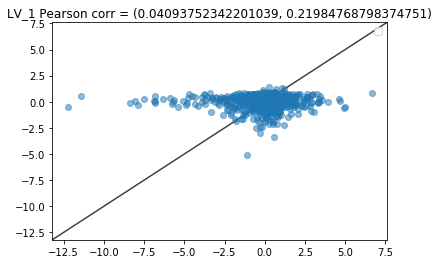

In [ ]:
A = np.array(valid_label.detach().numpy(), dtype=np.float)
A = A.flatten()
final_scores.detach().numpy()
B = np.array(valid_scores.detach().numpy(), dtype=np.float)
B = B.flatten()
scatter_plot (A, B, LV)

In [ ]:
ALASTOR_model_PATH = f"ALASTOR_model_{LV}_1.0.pt"
torch.save(model.state_dict(),ALASTOR_model_PATH)

In [ ]:
#train_data1, test_data, train_label1, test_label = train_test_split(data_X0, data_Y0, test_size=0.1, random_state=42)
#train_data, valid_data, train_label, valid_label = train_test_split(train_data1, train_label1, test_size=0.1, random_state=42)
#val_train_data, rest_data, val_train_label, rest_label = train_test_split(train_data, train_label, test_size=0.3, random_state=42)
print (type(train_data))
print (train_data.size())
print (valid_data.size())
# Final_Test_data = test_data + valid_data + val_train_data
# Final_Test_Label = test_label + valid_label + val_train_label

<class 'torch.Tensor'>
torch.Size([1350, 4, 2000])
torch.Size([900, 4, 2000])


In [ ]:
Final_Test_data = torch.cat((test_data , valid_data , val_train_data))
Final_Test_Label = torch.cat ((test_label , valid_label , val_train_label))
print (Final_Test_data.size())
print (Final_Test_Label.size())


torch.Size([2095, 4, 2000])
torch.Size([2095, 1])


In [ ]:
Final_Test_scores = model(Final_Test_data).squeeze()

/anaconda3/envs/theano/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/anaconda3/envs/theano/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
No handles

<Figure size 432x288 with 0 Axes>

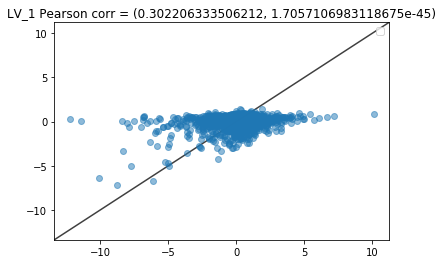

In [ ]:
A = np.array(Final_Test_Label.detach().numpy(), dtype=np.float)
A = A.flatten()
#Final_Test_scores.detach().numpy()
B = np.array(Final_Test_scores.detach().numpy(), dtype=np.float)
B = B.flatten()
scatter_plot (A, B, LV)